In [3]:
import pandas as pd
import dask as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats




/usr/local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [4]:
df = pd.read_csv('../data/JV_data_dist.csv')

In [5]:
#Filter data
df = df[df['mfgf'] == "Yes"]
df = df[df['sic'].str.contains('3711') == True]
df = df[df['public_count'] >= 1]
df = df[df['nump'] == 2]
df = df[df['avg_emp_pp'] >= 8]

#Recode variables
df['pdynamic'] = df['pdynamic'].map({'new_entrant': 1, 'incumbent': 0})	

In [21]:
y = df['pdynamic']
X = df['ddist_year']
X_constant = sm.add_constant(X, prepend=False)

## Assumption Testing

1. Appropriate outcome type: Satisfied since outcome is either new entrent or incumbent
2. Linearity of independent variables and log-odds: Satisfied
3. No strongly influential outliers: Satisfied
4. Absence of multicollinearity: Satisfied since it's a simple Logistical Reg. with one IV
5. Independence of observations: Satisfied since data is time series observations
6. Sufficiently large sample size: Satisfied since the dataset consists of >500 observations

### Assumption 2: Continuous IV is linearly related to the log odds

In [34]:
#Prepped data to R 
dfR = df.copy()
dfR['ddist_year'] = abs(dfR['ddist_year'])
dfR = dfR.drop(dfR[dfR['ddist_year'] == 0].index)
dfR['ddist_year'] = dfR['ddist_year']

dfR[['pdynamic', 'ddist_year', 'public_count']].to_csv('../data/prepped-r.csv', index=False)

#### Results from R:

In [ ]:
 MLE of lambda Score Statistic (z) Pr(>|z|)
        4.1824             -1.2029    0.229

p-value = 0.229, which is >0.05 (meaning that it is statistically not significant)
This means that there is linearity in the Discontinuity Distance feature, and the assumption has not violated

### Box Tidwell

In [17]:
df_lt = df.copy()  # lt = logit transform
df_lt['ddist_year'] = abs(df_lt['ddist_year'])
df_lt = df_lt.drop(df_lt[df_lt['ddist_year'] == 0].index)

# Define continuous variables
continuous_var = ['ddist_year']

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)

df_lt['Log_ddist_year'] = df_lt['ddist_year'].apply(lambda x: x * np.log(x)) #np.log = natural log


# Redefine independent variables to include interaction terms
X_lt = df_lt[['Log_ddist_year']]
y_lt = df_lt['pdynamic']

# Add constant
X_lt_constant = sm.add_constant(X_lt, prepend=False)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt_constant, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               pdynamic   No. Observations:                  175
Model:                            GLM   Df Residuals:                      173
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -119.15
Date:                Thu, 16 Jun 2022   Deviance:                       238.30
Time:                        22:17:50   Pearson chi2:                     175.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.004082
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Log_ddist_year     0.0414      0.049      0.

Non statistically significant, so the assumption is not violated.

#### Visual check

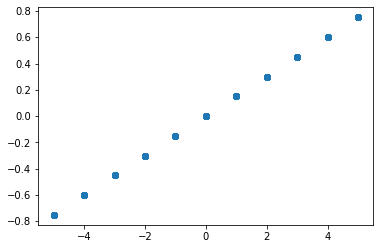

In [22]:
# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x=X.values, y=log_odds);
plt.show()

### Assumption 3: Lack of outliers

Cook’s Distance is an estimate of the influence of a data point. It takes into account both the leverage and residual of each observation. Cook’s Distance is a summary of how much a regression model changes when the ith observation is removed.
A general rule of thumb is that any observation with a Cook’s distance greater than 4/n (where n = total observations) is considered to be influential (https://www.statology.org/cooks-distance-python/ and https://www.scikit-yb.org/en/latest/api/regressor/influence.html?highlight=cook#module-yellowbrick.regressor.influence), though there are even more generic cutoff values of >0.5-1.0.
For outliers, we can use the absolute standardized residuals to identify them (std resid > 3)

In [23]:
logit_model = GLM(y, X_constant, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               pdynamic   No. Observations:                  202
Model:                            GLM   Df Residuals:                      200
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -130.98
Date:                Thu, 16 Jun 2022   Deviance:                       261.95
Time:                        22:19:55   Pearson chi2:                     202.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06781
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ddist_year     0.1629      0.045      3.637      0.0

In [24]:
# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df

,cooks_d,std_resid
5,0.002455,0.560925
6,0.002455,0.560925
8,0.024962,1.783862
10,0.024962,1.783862
11,0.002455,0.560925
...,...,...
977,0.011971,1.265524
978,0.011971,1.265524
982,0.011971,1.265524
985,0.004677,0.789196


In [25]:
# Set Cook's distance threshold
cook_threshold = 4 / len(X)
print(f"Threshold for Cook Distance = {cook_threshold}")

Threshold for Cook Distance = 0.019801980198019802


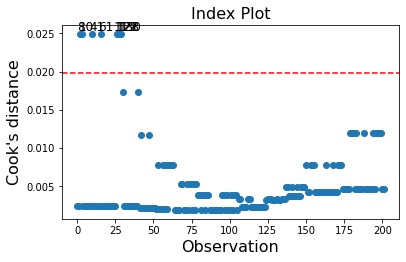

In [26]:
# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y=cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

In [27]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(X)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 4.0%


In [28]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(X)),1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')

Proportion of highly influential outliers = 0.0%


There are not outliers that can alter the reliability of the Logistical Regression Model

## Logistic Regression Model

In [30]:
model = smf.logit(formula="pdynamic~ ddist_year", data= df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.648401
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               pdynamic   No. Observations:                  202
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Jun 2022   Pseudo R-squ.:                 0.05137
Time:                        22:22:54   Log-Likelihood:                -130.98
converged:                       True   LL-Null:                       -138.07
Covariance Type:            nonrobust   LLR p-value:                 0.0001658
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3448      0.149     -2.309      0.021      -0.637      -0.052
ddist_year     0.1629      0.045      3.637      0.000       0.075       0.251
==============================================================================
"""

In [31]:
logit_model = GLM(y, X_constant, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               pdynamic   No. Observations:                  202
Model:                            GLM   Df Residuals:                      200
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -130.98
Date:                Thu, 16 Jun 2022   Deviance:                       261.95
Time:                        22:23:03   Pearson chi2:                     202.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06781
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ddist_year     0.1629      0.045      3.637      0.0